In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import sklearn
from sklearn.model_selection import KFold
import copy
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math
import time
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers import Dense , BatchNormalization , Dropout , Activation
from keras.layers import LSTM , GRU
#from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.optimizers import Adam , SGD , RMSprop

fileName="D:/Rajib/XLRI/Elective/Project/Final_Project/stock_price_2.csv"

C:\Users\m_raj\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#Reading data from the csv file
df=pd.read_csv(fileName,sep=",",low_memory=False, parse_dates=['Date'],
               usecols=['Symbol','Series','Date','Prev Close',
                      'Open Price','High Price',
                      'Low Price','Last Price','Close Price',
                      'Average Price','Total Traded Quantity',
                      'Turnover','No. of Trades','Deliverable Qty',
                      '% Dly Qt to Traded Qty'])

In [3]:
print("Current shape of dataset :",df.shape)

Current shape of dataset : (4945, 15)


In [4]:
df.head()

,Symbol,Series,Date,Prev Close,Open Price,High Price,Low Price,Last Price,Close Price,Average Price,Total Traded Quantity,Turnover,No. of Trades,Deliverable Qty,% Dly Qt to Traded Qty
0,BPCL,EQ,2015-01-01,646.00,648.9,657.50,642.20,654.45,654.20,650.33,482167,3.135670e+08,9126,128226,26.59
1,BPCL,EQ,2015-01-02,654.20,650.9,655.90,642.45,646.75,644.40,648.43,1023715,6.638094e+08,20920,453708,44.32
2,BPCL,EQ,2015-01-05,644.40,645.0,649.45,641.30,646.00,645.65,645.09,1094372,7.059689e+08,26953,541239,49.46
3,BPCL,EQ,2015-01-06,645.65,652.4,655.30,630.00,640.00,639.15,644.43,2186835,1.409260e+09,45768,1208954,55.28
4,BPCL,EQ,2015-01-07,639.15,637.0,649.35,637.00,646.00,644.95,644.83,1309394,8.443390e+08,47084,764599,58.39


In [5]:
#Concise summary of a DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4945 entries, 0 to 4944
Data columns (total 15 columns):
Symbol                    4945 non-null object
Series                    4945 non-null object
Date                      4945 non-null datetime64[ns]
Prev Close                4945 non-null float64
Open Price                4945 non-null float64
High Price                4945 non-null float64
Low Price                 4945 non-null float64
Last Price                4945 non-null float64
Close Price               4945 non-null float64
Average Price             4945 non-null float64
Total Traded Quantity     4945 non-null int64
Turnover                  4945 non-null float64
No. of Trades             4945 non-null int64
Deliverable Qty           4945 non-null int64
% Dly Qt to Traded Qty    4945 non-null float64
dtypes: datetime64[ns](1), float64(9), int64(3), object(2)
memory usage: 579.6+ KB


In [6]:
#Generates descriptive statistics that summarize the central tendency,
#dispersion and shape of a dataset’s distribution, excluding NaN value
df.describe(include = 'all')

,Symbol,Series,Date,Prev Close,Open Price,High Price,Low Price,Last Price,Close Price,Average Price,Total Traded Quantity,Turnover,No. of Trades,Deliverable Qty,% Dly Qt to Traded Qty
count,4945,4945,4945,4945.000000,4945.000000,4945.000000,4945.000000,4945.000000,4945.000000,4945.000000,4.945000e+03,4.945000e+03,4945.000000,4.945000e+03,4945.000000
unique,5,1,989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,IOC,EQ,2017-08-21 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,989,4945,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,NaN,2015-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2018-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,435.386168,435.789191,441.870536,429.101587,435.186805,435.174115,435.485361,4.032784e+06,1.365271e+09,51799.528413,2.049989e+06,50.366595
std,NaN,NaN,NaN,218.446312,218.616894,221.821262,215.529510,218.632718,218.510140,218.746215,4.497435e+06,1.159818e+09,32524.342980,2.379728e+06,12.769016
min,NaN,NaN,NaN,118.050000,122.000000,125.700000,105.250000,117.500000,118.050000,117.900000,8.788700e+04,3.074063e+07,1494.000000,3.141000e+04,9.570000
25%,NaN,NaN,NaN,295.650000,295.300000,300.650000,290.500000,295.550000,295.250000,294.970000,1.533272e+06,7.267455e+08,30934.000000,7.261290e+05,41.440000


In [7]:
## Remove columns  not related to our target variable
removefields=['No. of Trades','Deliverable Qty','% Dly Qt to Traded Qty']
df = df.drop(labels = removefields, axis = 1) 


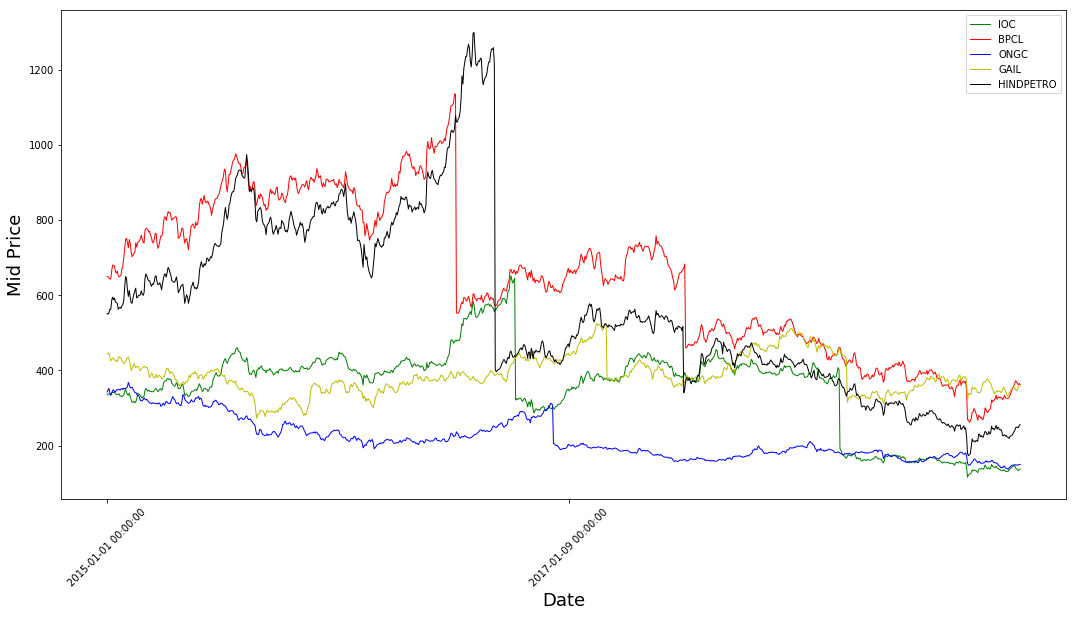

In [8]:
dfIOC=df[df['Symbol']=='IOC']
dfBPCL=df[df['Symbol']=='BPCL']
dfGAIL=df[df['Symbol']=='GAIL']
dfONGC=df[df['Symbol']=='ONGC']
#dfRELIANCE=df[df['Symbol']=='RELIANCE']
dfHIND=df[df['Symbol']=='HINDPETRO']
plt.figure(figsize = (18,9))
plt.plot(range(dfIOC.shape[0]),(dfIOC['Low Price']+dfIOC['High Price'])/2.0,'g',label='IOC', linewidth=1)
plt.plot(range(dfBPCL.shape[0]),(dfBPCL['Low Price']+dfBPCL['High Price'])/2.0,'r',label='BPCL', linewidth=1)
plt.plot(range(dfONGC.shape[0]),(dfONGC['Low Price']+dfONGC['High Price'])/2.0,'b',label='ONGC', linewidth=1)
plt.plot(range(dfGAIL.shape[0]),(dfGAIL['Low Price']+dfGAIL['High Price'])/2.0,'y',label='GAIL', linewidth=1)
plt.plot(range(dfHIND.shape[0]),(dfHIND['Low Price']+dfHIND['High Price'])/2.0,'k',label='HINDPETRO', linewidth=1)
#plt.plot(range(dfRELIANCE.shape[0]),(dfRELIANCE['Low Price']+dfRELIANCE['High Price'])/2.0,'c',label='RELIANCE', linewidth=1)
plt.xticks(range(0,dfIOC.shape[0],500),dfIOC['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.legend()
plt.show()

In [9]:
 df['Date'] = pd.to_datetime(df['Date'])
techIndicator = copy.deepcopy(df)
#techIndicator.reset_index(drop=True)

In [10]:
#Calculation of Relative Strength Index (RSI)
# Relative Strength Index
# Avg(PriceUp)/(Avg(PriceUP)+Avg(PriceDown)*100
# Where: PriceUp(t)=1*(Price(t)-Price(t-1)){Price(t)- Price(t-1)>0};
#        PriceDown(t)=-1*(Price(t)-Price(t-1)){Price(t)- Price(t-1)<0};

def rsi(values):
    up = values[values>0].mean()
    down = -1*values[values<0].mean()
    return 100 * up / (up + down)

In [11]:
#Calculation of Bollinger Bands¶

def bbands(price, length=30, numsd=2):
    """ returns average, upper band, and lower band"""
    #ave = pd.stats.moments.rolling_mean(price,length)
    ave = price.rolling(window = length, center = False).mean()
    #sd = pd.stats.moments.rolling_std(price,length)
    sd = price.rolling(window = length, center = False).std()
    upband = ave + (sd*numsd)
    dnband = ave - (sd*numsd)
    return np.round(ave,3), np.round(upband,3), np.round(dnband,3)

In [12]:
#Calculation of Stochastic Oscillator (%K and %D)¶
def STOK(df, n):
    df['STOK'] = ((df['Close Price'] - df['Low Price'].rolling(window=n, center=False).mean()) / (df['High Price'].rolling(window=n, center=False).max() - df['Low Price'].rolling(window=n, center=False).min())) * 100
    df['STOD'] = df['STOK'].rolling(window = 3, center=False).mean()

In [13]:
#Calculation of Money Flow Index
def MFI(df):
    # typical price
    df['tp'] = (df['High Price']+df['Low Price']+df['Close Price'])/3
    #raw money flow
    df['rmf'] = df['tp'] * df['Total Traded Quantity']
    
    # positive and negative money flow
    df['pmf'] = np.where(df['tp'] > df['tp'].shift(1), df['tp'], 0)
    df['nmf'] = np.where(df['tp'] < df['tp'].shift(1), df['tp'], 0)

    # money flow ratio
    df['mfr'] = df['pmf'].rolling(window=14,center=False).sum()/df['nmf'].rolling(window=14,center=False).sum()
    df['Money_Flow_Index'] = 100 - 100 / (1 + df['mfr'])

In [14]:
#Calculation of MINMAX

def MINMAX(df):
    df['MIN_Volume'] = df['Total Traded Quantity'].rolling(window=14,center=False).min()
    df['MAX_Volume'] = df['Total Traded Quantity'].rolling(window=14,center=False).max()

In [15]:
def CCI(df, n, constant):
    TP = (df['High'] + df['Low'] + df['Close']) / 3
    CCI = pd.Series((TP - TP.rolling(window=n, center=False).mean()) / (constant * TP.rolling(window=n, center=False).std())) #, name = 'CCI_' + str(n))
    return CCI

In [16]:
# Add Momentum_1D column for all 15 stocks.
# Momentum_1D = P(t) - P(t-1)
STOK(techIndicator, 4)
MFI(techIndicator)
MINMAX(techIndicator)
for stock in range(len(techIndicator)):
   # print(stock)
    #MFI(techIndicator[stock])
    #techIndicator[stock] = techIndicator[stock].fillna(0)
    techIndicator['Momentum_1D'] = (techIndicator['Close Price']-techIndicator['Close Price'].shift(1)).fillna(0)
    techIndicator['RSI_14D'] = techIndicator['Momentum_1D'].rolling(center=False, window=14).apply(rsi).fillna(0)
    techIndicator['Momentum'] = techIndicator['Close Price'] - techIndicator['Close Price'].shift(4)
    techIndicator['Volume_plain'] = techIndicator['Total Traded Quantity'].fillna(0)
    techIndicator['BB_Middle_Band'], techIndicator['BB_Upper_Band'], techIndicator['BB_Lower_Band'] = bbands(techIndicator['Close Price'], length=20, numsd=1)
    techIndicator['BB_Middle_Band'] = techIndicator['BB_Middle_Band'].fillna(0)
    techIndicator['BB_Upper_Band'] = techIndicator['BB_Upper_Band'].fillna(0)
    techIndicator['BB_Lower_Band'] = techIndicator['BB_Lower_Band'].fillna(0)
    techIndicator['ROC'] = ((techIndicator['Close Price'] - techIndicator['Close Price'].shift(12))/(techIndicator['Close Price'].shift(12)))*100
    #Calculation of Triple Exponential Moving Average
    #Triple Exponential MA Formula:
    #T-EMA = (3EMA – 3EMA(EMA)) + EMA(EMA(EMA))
    #Where:  #EMA = EMA(1) + α * (Close – EMA(1))
    #α = 2 / (N + 1)  #N = The smoothing period.
    techIndicator['EMA'] = techIndicator['Close Price'].ewm(span=3,min_periods=0,adjust=True,ignore_na=False).mean()
    techIndicator['TEMA'] = (3 * techIndicator['EMA'] - 3 * techIndicator['EMA'] * techIndicator['EMA']) + (techIndicator['EMA']*techIndicator['EMA']*techIndicator['EMA'])
     #Calculation of MACD #MACD: (12-day EMA - 26-day EMA)
    techIndicator['26_ema'] = techIndicator['Close Price'].ewm(span=26,min_periods=0,adjust=True,ignore_na=False).mean()
    techIndicator['12_ema'] = techIndicator['Close Price'].ewm(span=12,min_periods=0,adjust=True,ignore_na=False).mean()
    techIndicator['MACD'] = techIndicator['12_ema'] - techIndicator['26_ema']
    #STOK(techIndicator, 4)

C:\Users\m_raj\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  # This is added back by InteractiveShellApp.init_path()


In [17]:
techIndicator.head()

,Symbol,Series,Date,Prev Close,Open Price,High Price,Low Price,Last Price,Close Price,Average Price,...,Volume_plain,BB_Middle_Band,BB_Upper_Band,BB_Lower_Band,ROC,EMA,TEMA,26_ema,12_ema,MACD
0,BPCL,EQ,2015-01-01,646.00,648.9,657.50,642.20,654.45,654.20,650.33,...,482167,0.0,0.0,0.0,NaN,654.200000,2.787010e+08,654.200000,654.200000,0.000000
1,BPCL,EQ,2015-01-02,654.20,650.9,655.90,642.45,646.75,644.40,648.43,...,1023715,0.0,0.0,0.0,NaN,647.666667,2.704216e+08,649.111538,648.891667,-0.219872
2,BPCL,EQ,2015-01-05,644.40,645.0,649.45,641.30,646.00,645.65,645.09,...,1094372,0.0,0.0,0.0,NaN,646.514286,2.689785e+08,647.867841,647.626443,-0.241398
3,BPCL,EQ,2015-01-06,645.65,652.4,655.30,630.00,640.00,639.15,644.43,...,2186835,0.0,0.0,0.0,NaN,642.586667,2.640985e+08,645.430714,644.950761,-0.479952
4,BPCL,EQ,2015-01-07,639.15,637.0,649.35,637.00,646.00,644.95,644.83,...,1309394,0.0,0.0,0.0,NaN,643.806452,2.656077e+08,645.319234,644.950555,-0.368680


In [18]:
techIndicator.shape

(4945, 35)

In [19]:
techIndicator.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4945 entries, 0 to 4944
Data columns (total 35 columns):
Symbol                   4945 non-null object
Series                   4945 non-null object
Date                     4945 non-null datetime64[ns]
Prev Close               4945 non-null float64
Open Price               4945 non-null float64
High Price               4945 non-null float64
Low Price                4945 non-null float64
Last Price               4945 non-null float64
Close Price              4945 non-null float64
Average Price            4945 non-null float64
Total Traded Quantity    4945 non-null int64
Turnover                 4945 non-null float64
STOK                     4942 non-null float64
STOD                     4940 non-null float64
tp                       4945 non-null float64
rmf                      4945 non-null float64
pmf                      4945 non-null float64
nmf                      4945 non-null float64
mfr                      4932 non-null float

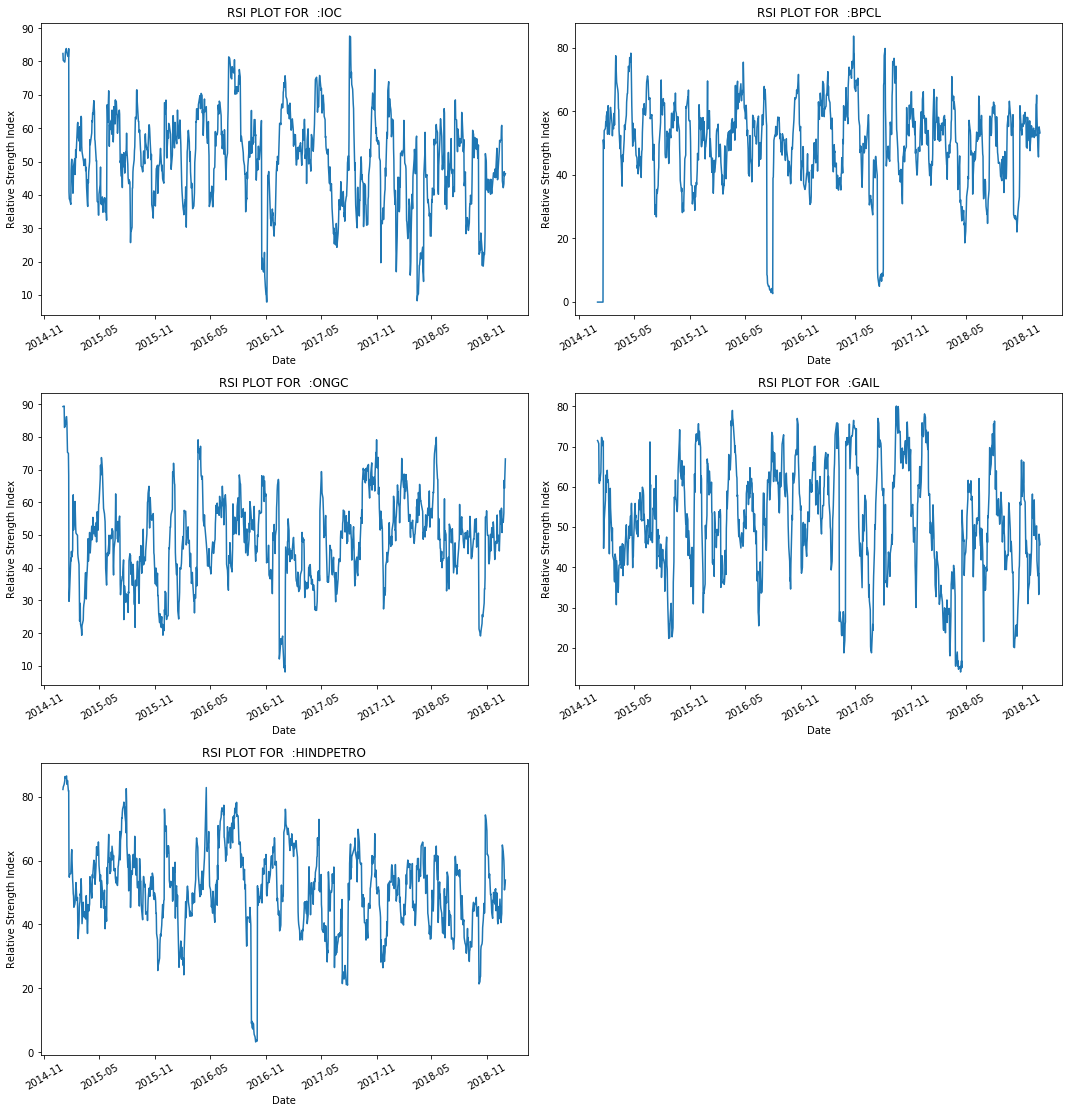

In [20]:
# RSI Plot

ticker={'IOC':'IOC',
        'BPCL':'BPCL',
        'ONGC':'ONGC',
        'GAIL':'GAIL',
        'HINDPETRO': 'HINDPETRO'
       }
i=0
fig = plt.figure(figsize=(15,20))
for  stock in ticker.values():
    ax = plt.subplot(4,2,i+1)
    i=i+1
    dfRS=techIndicator[techIndicator['Symbol']==stock] 
    ax.plot(dfRS['Date'],dfRS['RSI_14D'])
    ax.set_title("RSI PLOT FOR  :" +str(stock))
    ax.set_xlabel("Date")
    ax.set_ylabel("Relative Strength Index")
    plt.xticks(rotation=30)
fig.tight_layout()


C:\Users\m_raj\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


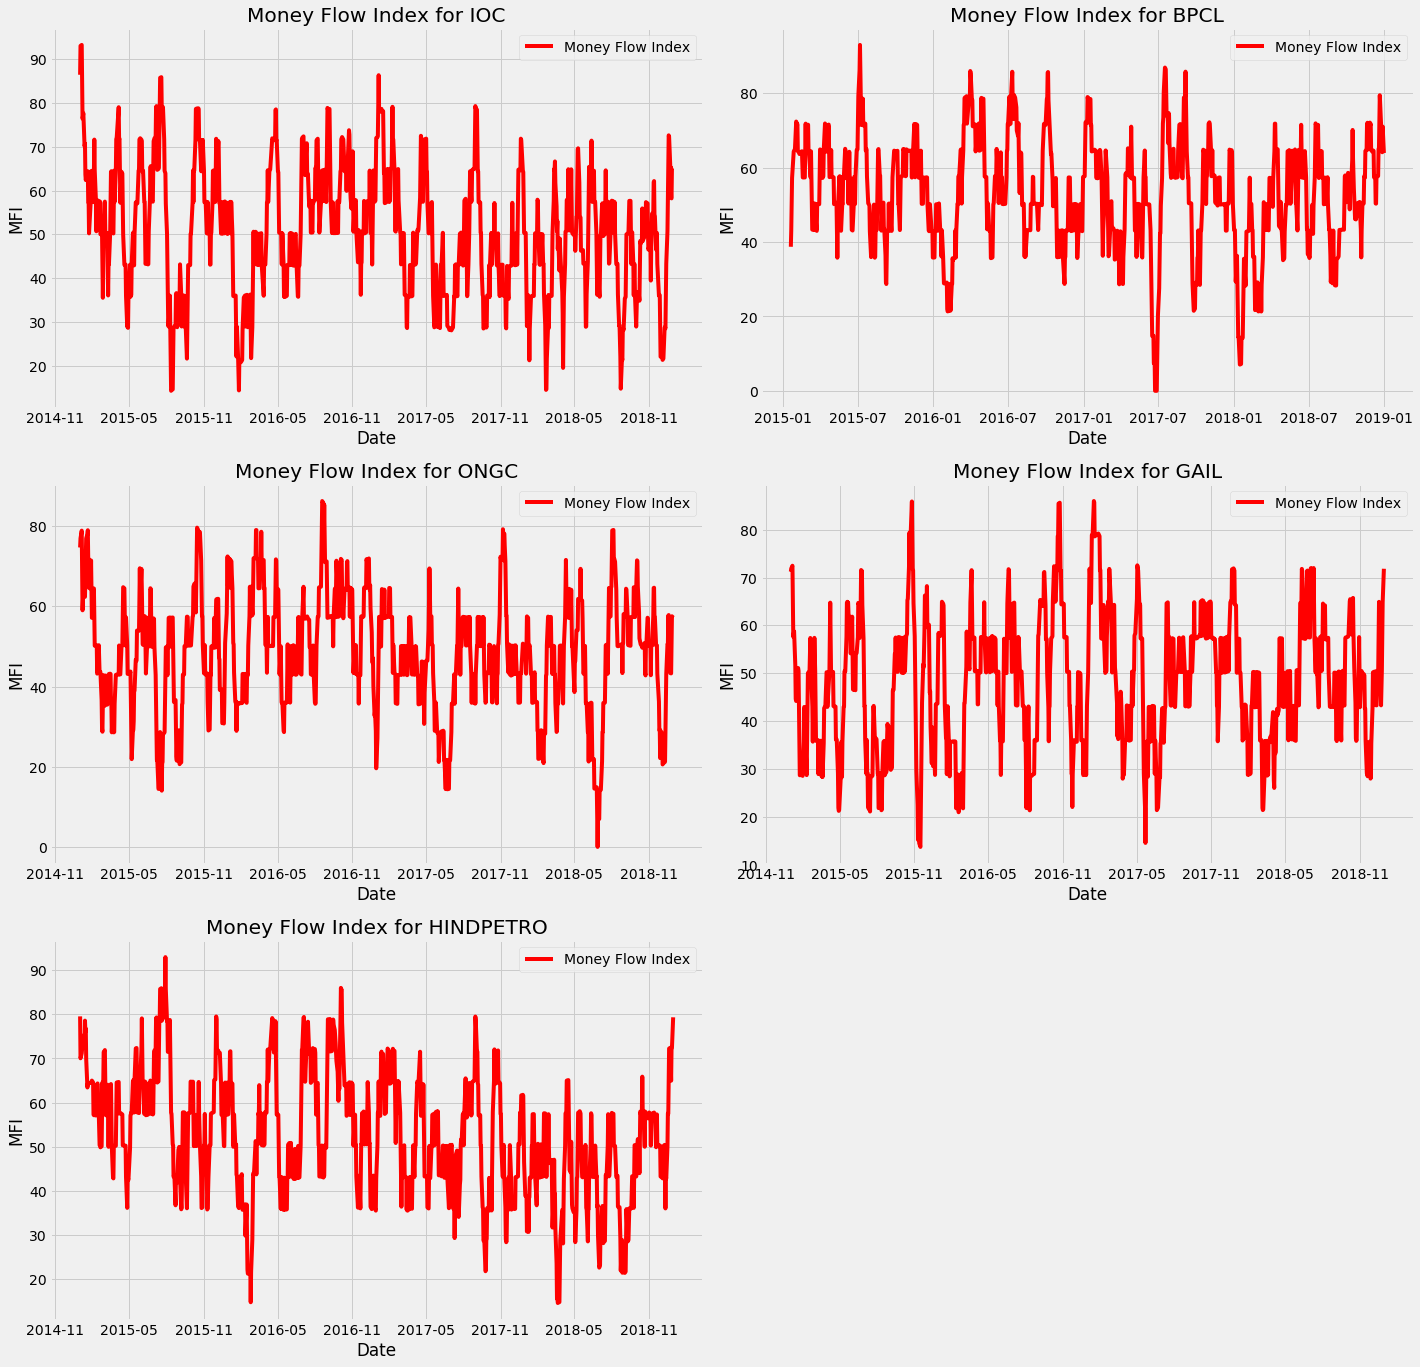

In [21]:
#  Money Flow
ticker={'IOC':'IOC',
        'BPCL':'BPCL',
        'ONGC':'ONGC',
        'GAIL':'GAIL',
        'HINDPETRO': 'HINDPETRO'
       }
i=0
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(20,25))
for  stock in ticker.values():
    ax = plt.subplot(4,2,i+1)
    i=i+1
    dfMFI=techIndicator[techIndicator['Symbol']==stock] 
    dfMFI['Date'] = pd.to_datetime(dfMFI['Date'])
    t = ax.plot(dfMFI['Date'],dfMFI['Money_Flow_Index'], 'red', label="Money Flow Index")
    t = ax.set_title("Money Flow Index for " +str(stock))
    t = ax.set_ylabel("MFI")
    ax.legend()
    #ax.set_title("CCI, TEMA, OBV for " +str(techindi2[i]['Label'][0]))
    ax.set_xlabel("Date")
    fig.add_subplot(ax)
fig.tight_layout()

C:\Users\m_raj\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


(989, 35)
(989, 35)
(989, 35)
(989, 35)
(989, 35)


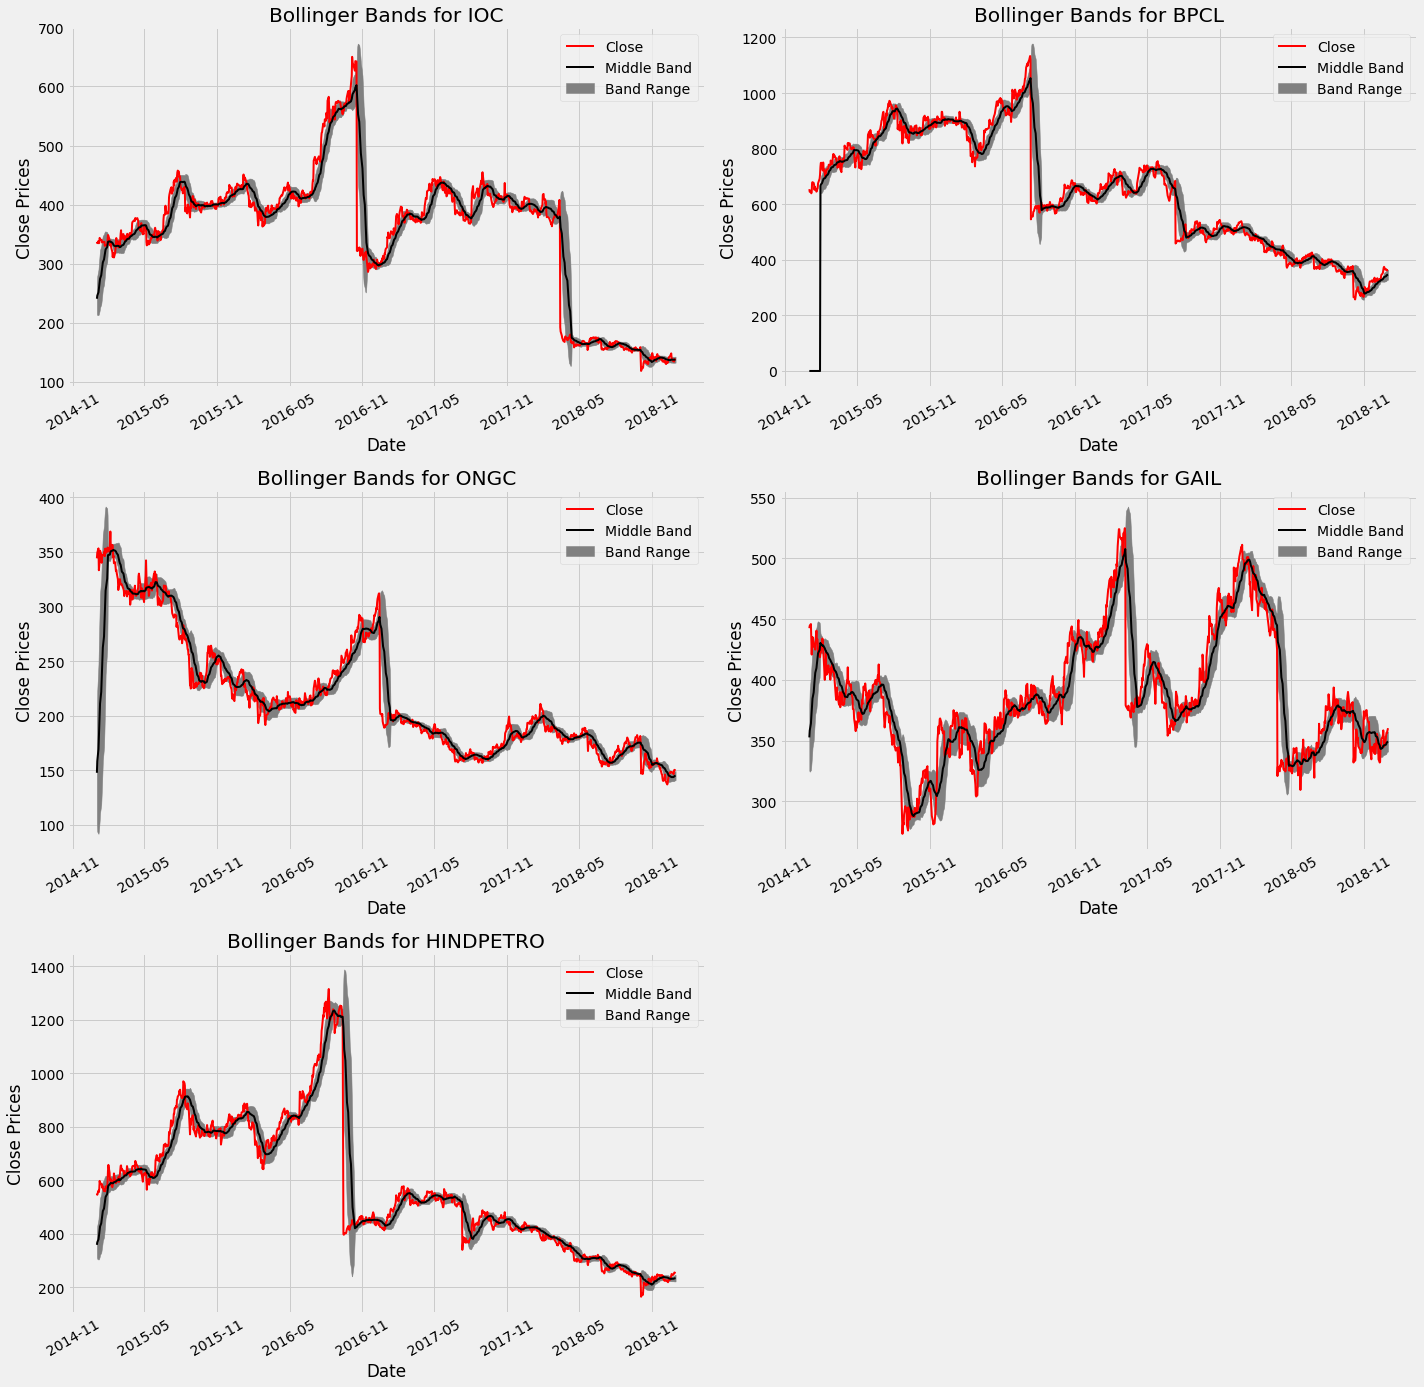

In [22]:
#Bolinger Band Plot
ticker={'IOC':'IOC',
        'BPCL':'BPCL',
        'ONGC':'ONGC',
        'GAIL':'GAIL',
        'HINDPETRO': 'HINDPETRO'
       }
i=0
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(20,25))
for  stock in ticker.values():
    ax = plt.subplot(4,2,i+1)
    i=i+1
    dfBolinger=techIndicator[techIndicator['Symbol']==stock] 
    dfBolinger['Date'] = pd.to_datetime(dfBolinger['Date'])
    #dfBolinger.reset_index()
    # Set new index
    #dfBolinger.set_index(pd.DatetimeIndex(dfBolinger['date']), inplace=True)
    print(dfBolinger.shape)
    #index=pd.date_range(start=dfBolinger['Date'].min(), end=dfBolinger['Date'].max(), freq='D')
    ax.fill_between(dfBolinger['Date'].values ,dfBolinger['BB_Upper_Band'],dfBolinger['BB_Lower_Band'], color='grey', label="Band Range")
    # Plot Adjust Closing Price and Moving Averages
    ax.plot(dfBolinger['Date'], dfBolinger['Close Price'], color='red', lw=2, label="Close")
    ax.plot(dfBolinger['Date'], dfBolinger['BB_Middle_Band'], color='black', lw=2, label="Middle Band")
    ax.set_title("Bollinger Bands for " + str(stock))
    ax.legend()
    ax.set_xlabel("Date")
    ax.set_ylabel("Close Prices")
    plt.xticks(rotation=30)
fig.tight_layout()

C:\Users\m_raj\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


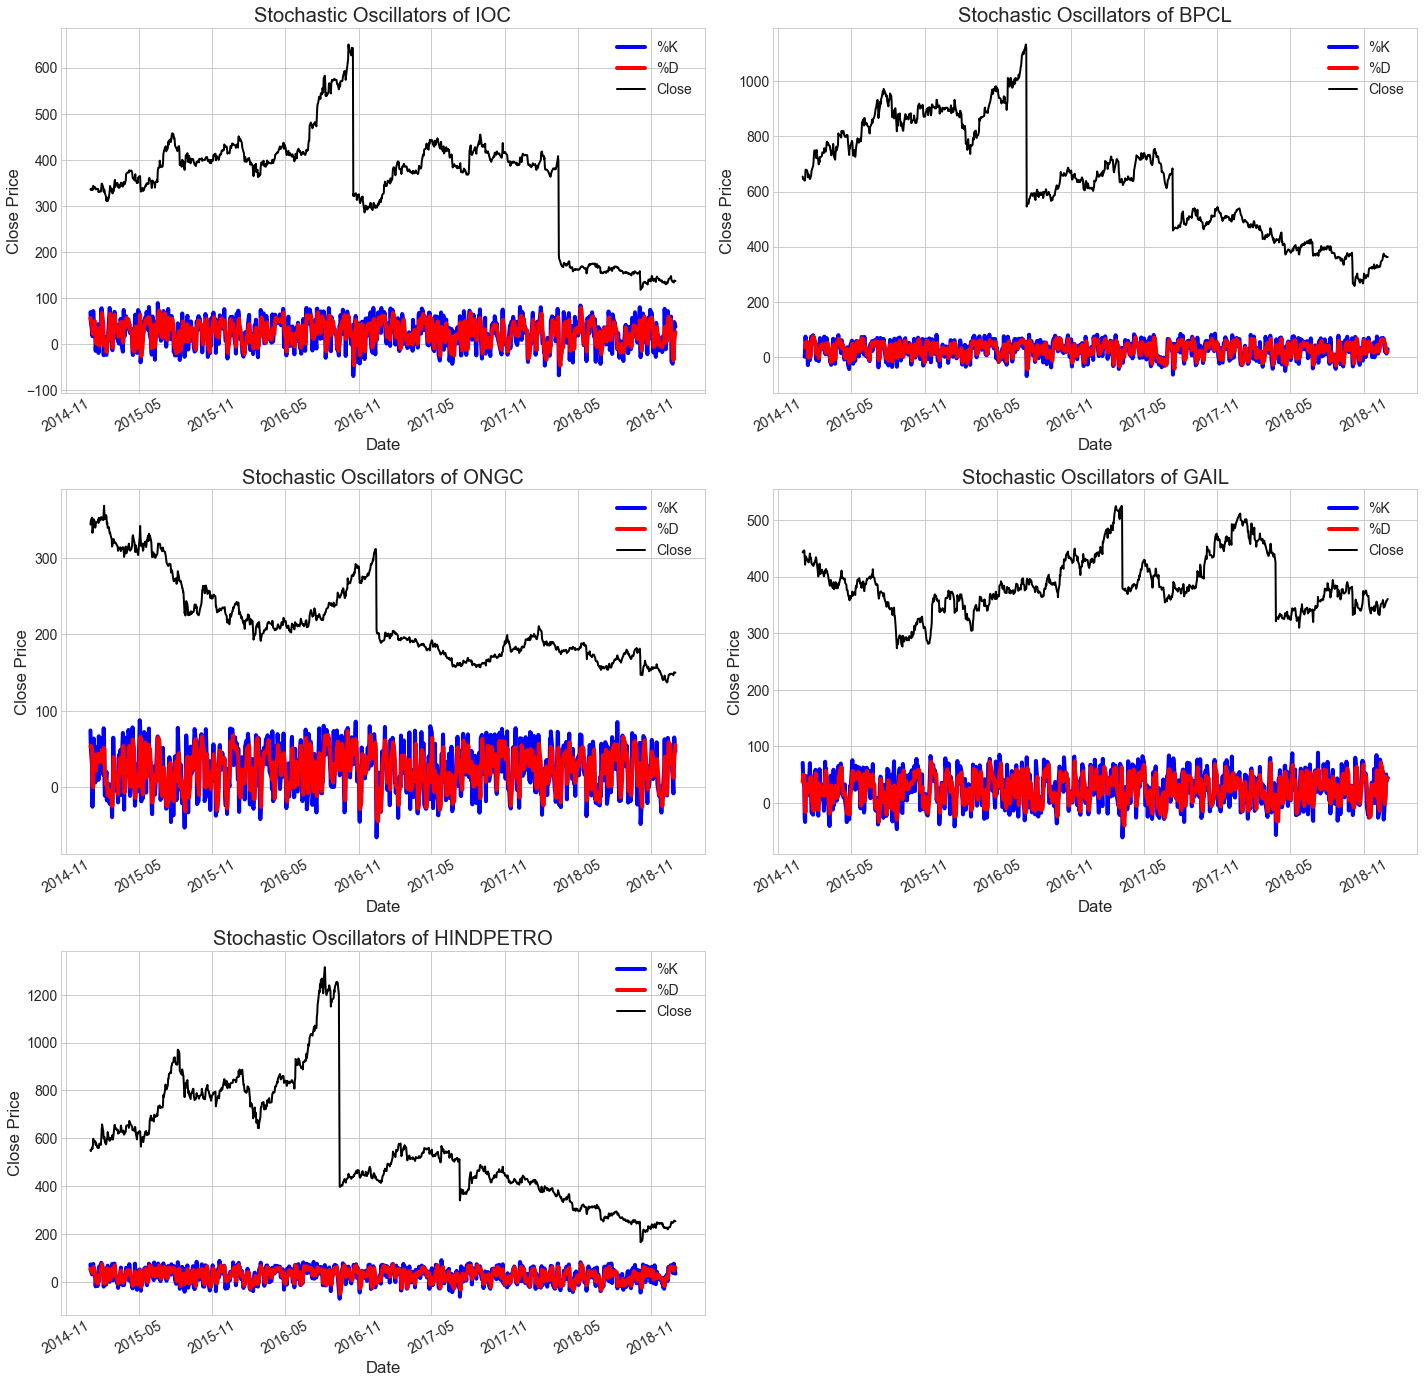

In [23]:
# Stochastic Oscillator plots
ticker={'IOC':'IOC',
        'BPCL':'BPCL',
        'ONGC':'ONGC',
        'GAIL':'GAIL',
        'HINDPETRO': 'HINDPETRO'
       }
i=0
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,25))
#for i in range(8):
for  stock in ticker.values():
    ax = plt.subplot(4,2,i+1)
    i=i+1
    dfStochastic=techIndicator[techIndicator['Symbol']==stock] 
    dfStochastic['Date'] = pd.to_datetime(dfStochastic['Date'])
    ax.plot(dfStochastic['Date'].values , dfStochastic['STOK'], 'blue', label="%K")
    ax.plot(dfStochastic['Date'].values , dfStochastic['STOD'], 'red', label="%D")
    ax.plot(dfStochastic['Date'].values , dfStochastic['Close Price'], color='black', lw=2, label = "Close")
    ax.set_title("Stochastic Oscillators of " +str(stock))
    ax.legend()
    ax.set_xlabel("Date")
    ax.set_ylabel("Close Price")
    plt.xticks(rotation=30)
fig.tight_layout()

C:\Users\m_raj\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


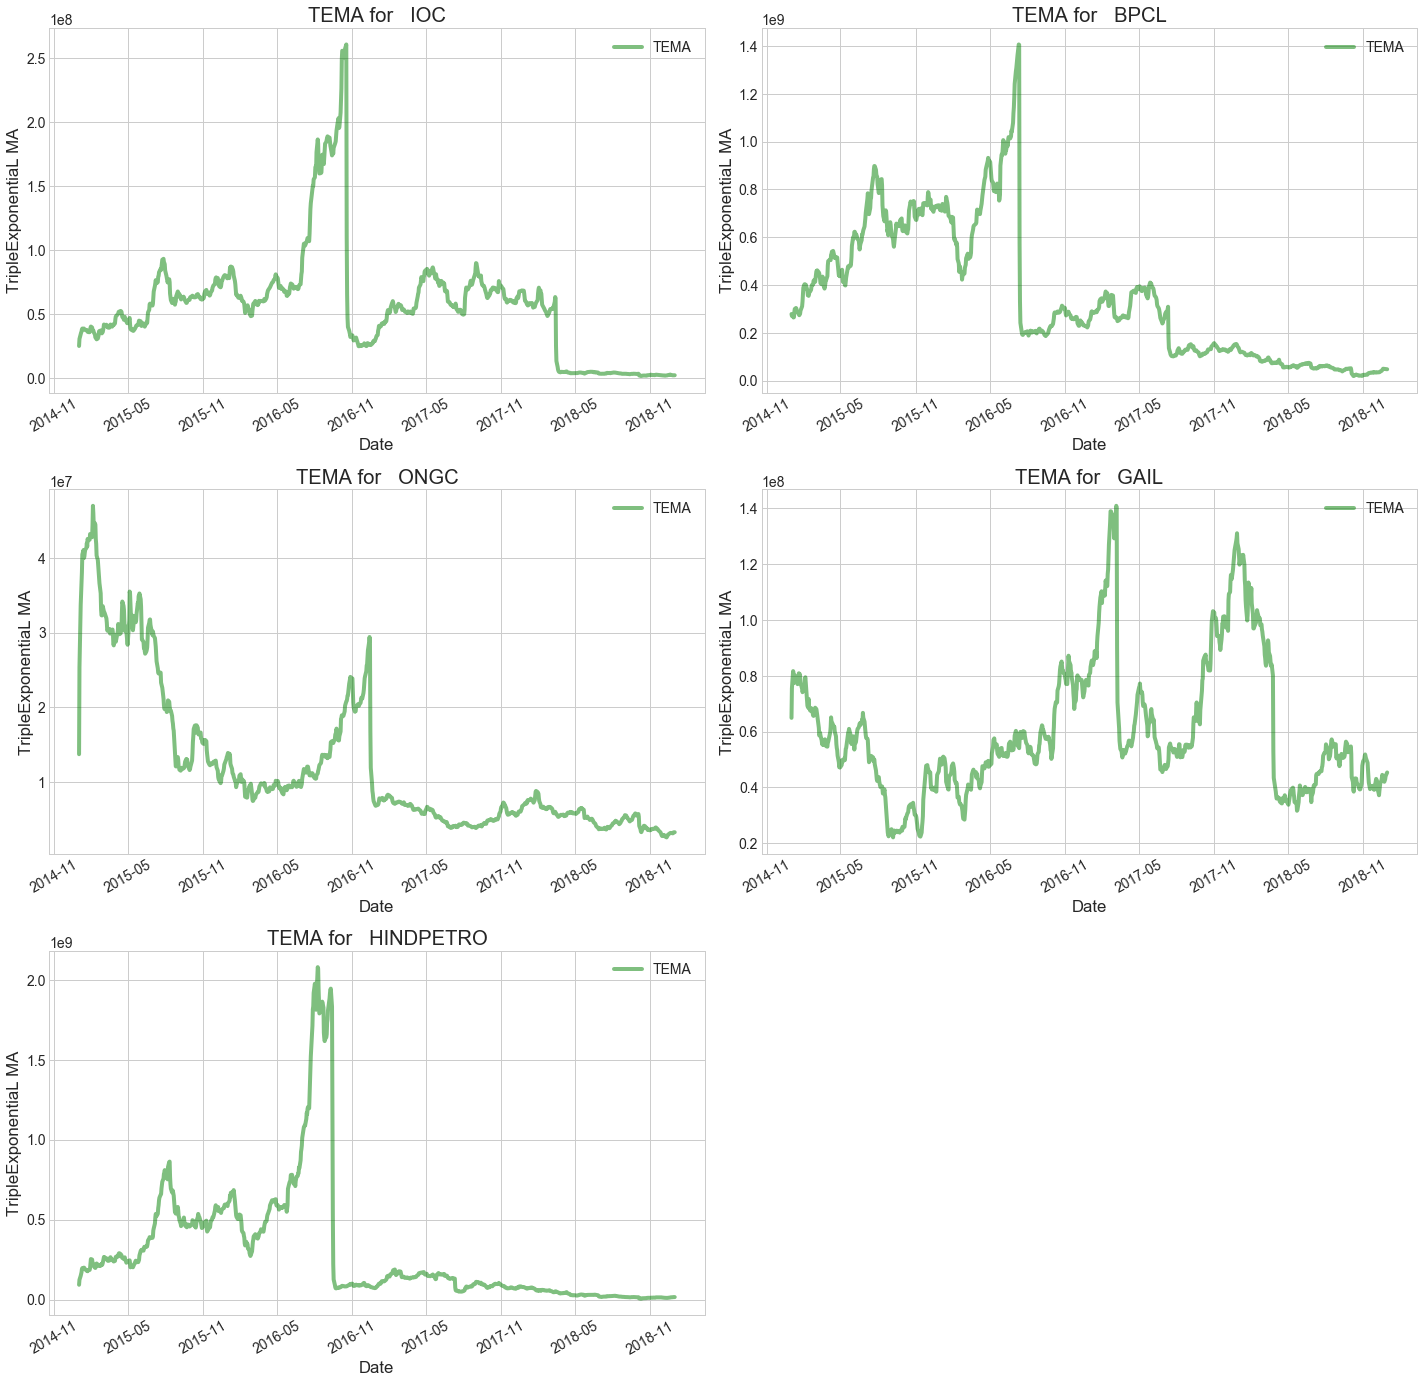

In [24]:
#TEMA Plot

ticker={'IOC':'IOC',
        'BPCL':'BPCL',
        'ONGC':'ONGC',
        'GAIL':'GAIL',
        'HINDPETRO': 'HINDPETRO'
       }
i=0
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,25))
for  stock in ticker.values():
    ax = plt.subplot(4,2,i+1)
    i=i+1
    dfTema=techIndicator[techIndicator['Symbol']==stock] 
    dfTema['Date'] = pd.to_datetime(dfTema['Date'])
    ax.plot(dfTema['Date'].values, dfTema['TEMA'], 'green', label="TEMA", alpha = 0.5)
    #ax.plot(dfMACD['Date'].values, dfMACD['Close Price'], 'red', label="Close", alpha = 0.5)
    ax.set_title("TEMA for   " +str(stock))
    ax.legend()
    ax.set_xlabel("Date")
    ax.set_ylabel("TripleExponentiaL MA")
    plt.xticks(rotation=30)
fig.tight_layout()

C:\Users\m_raj\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


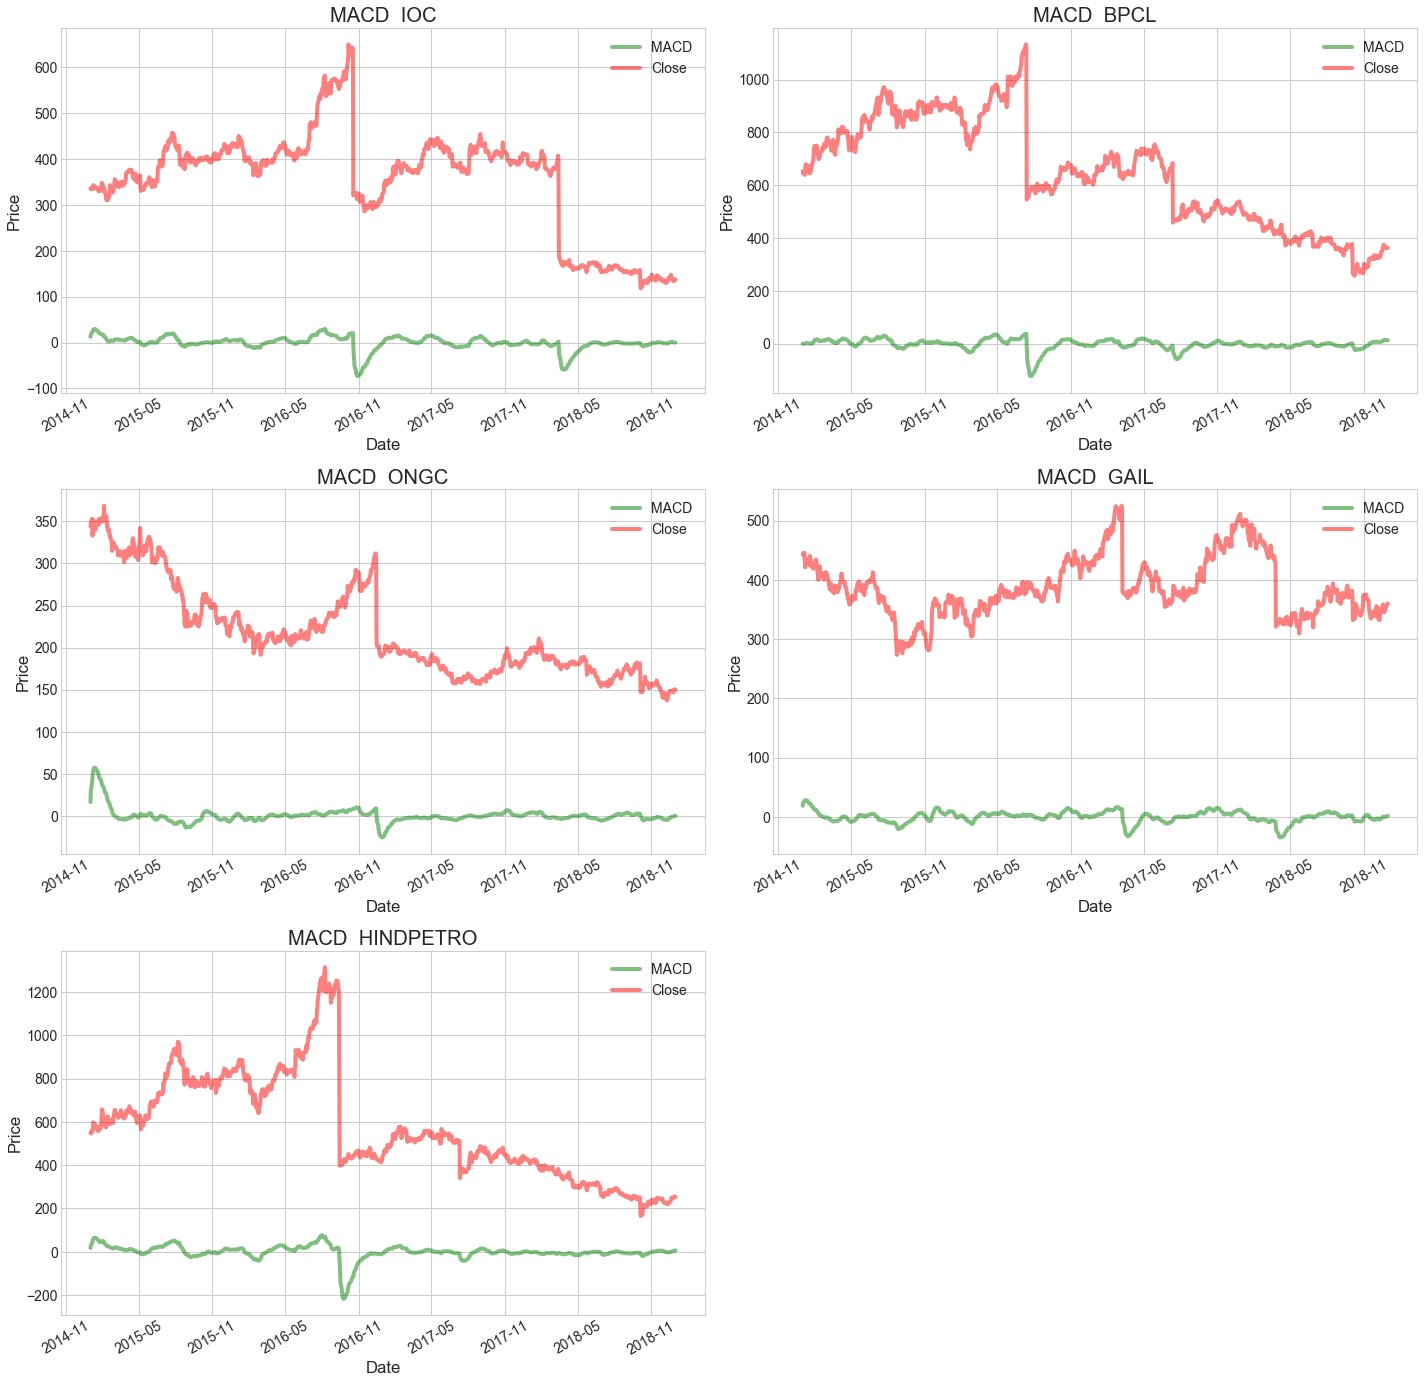

In [25]:
# MACD and CLOSE PRICE
#MACD Plot

ticker={'IOC':'IOC',
        'BPCL':'BPCL',
        'ONGC':'ONGC',
        'GAIL':'GAIL',
        'HINDPETRO': 'HINDPETRO'
       }
i=0
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,25))
for  stock in ticker.values():
    ax = plt.subplot(4,2,i+1)
    i=i+1
    dfMACD=techIndicator[techIndicator['Symbol']==stock] 
    dfMACD['Date'] = pd.to_datetime(dfMACD['Date'])
    ax.plot(dfMACD['Date'].values, dfMACD['MACD'], 'green', label="MACD", alpha = 0.5)
    ax.plot(dfMACD['Date'].values, dfMACD['Close Price'], 'red', label="Close", alpha = 0.5)
    ax.set_title("MACD  " +str(stock))
    ax.legend()
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    plt.xticks(rotation=30)
fig.tight_layout()

 

In [26]:
# function for min-max normalization of stock
def normalizeData(df):
    minMaxScaler = sklearn.preprocessing.MinMaxScaler()
    df['Open Price'] = minMaxScaler.fit_transform(df['Open Price'].values.reshape(-1,1))
    df['High Price'] = minMaxScaler.fit_transform(df['High Price'].values.reshape(-1,1))
    df['Low Price'] = minMaxScaler.fit_transform(df['Low Price'].values.reshape(-1,1))
    df['Close Price'] = minMaxScaler.fit_transform(df['Close Price'].values.reshape(-1,1))
    return df

In [27]:
usecols=(['Date','Open Price','High Price',
        'Low Price','Last Price','Close Price'])

stockpredictdf=pd.read_csv(fileName,sep=",",low_memory=False, parse_dates=['Date'],
               usecols=usecols,index_col = 0)
#stockpredictdf = df[usecols]
#stockpredictdf.loc[:,'Date']
#stockpredictdf.set_index('Date')
stockpredictdf = normalizeData(stockpredictdf)


stockpredictdf.head()

,Open Price,High Price,Low Price,Last Price,Close Price
Date,,,,,
2015-01-01,0.439816,0.442319,0.460249,654.45,0.447762
2015-01-02,0.441486,0.440988,0.460464,646.75,0.439577
2015-01-05,0.436561,0.435623,0.459478,646.00,0.440621
2015-01-06,0.442738,0.440489,0.449792,640.00,0.435193
2015-01-07,0.429883,0.435540,0.455792,646.00,0.440037


In [28]:
#Create training set and testing set
def loadData(stock, seqLen):
    noOfFeatures = len(stock.columns) 
    data = stock.as_matrix() 
    sequenceLength = seqLen + 1 # index starting from 0
    result = []
    
    for index in range(len(data) - sequenceLength): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + sequenceLength]) # index : index + 22days
    
    result = np.array(result)
    row = round(0.9 * result.shape[0]) # 90% split
    train = result[:int(row), :] # 90% date, all features 
    
    xTrain = train[:, :-1] 
    yTrain = train[:, -1][:,-1]
    
    xTest = result[int(row):, :-1] 
    yTest = result[int(row):, -1][:,-1]

    xTrain = np.reshape(xTrain, (xTrain.shape[0], xTrain.shape[1], noOfFeatures))
    xTest = np.reshape(xTest, (xTest.shape[0], xTest.shape[1], noOfFeatures))  

    return [xTrain, yTrain, xTest, yTest]

In [29]:
##Build Model
def buildModel(layers):
    d = 0.3
    model = Sequential()
    
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
    
    # adam = keras.optimizers.Adam(decay=0.2)
        
    start = time.time()
    model.compile(loss='mse',optimizer='adam', metrics=['mean_squared_error'])
    print("Compilation Time : ", time.time() - start)
    return model

In [30]:
window = 22
XTrain, yTrain, XTest, yTest = loadData(stockpredictdf, window)
print (XTrain[0], yTrain[0])

[[4.39816361e-01 4.42318889e-01 4.60249432e-01 6.54450000e+02
  4.47761817e-01]
 [4.41485810e-01 4.40988106e-01 4.60463721e-01 6.46750000e+02
  4.39577418e-01]
 [4.36560935e-01 4.35623389e-01 4.59477993e-01 6.46000000e+02
  4.40621346e-01]
 [4.42737896e-01 4.40489063e-01 4.49792140e-01 6.40000000e+02
  4.35192918e-01]
 [4.29883139e-01 4.35540215e-01 4.55792226e-01 6.46000000e+02
  4.40036746e-01]
 [4.39899833e-01 4.62613324e-01 4.66078087e-01 6.80400000e+02
  4.67304159e-01]
 [4.69115192e-01 4.67686933e-01 4.86221232e-01 6.77950000e+02
  4.68765659e-01]
 [4.69949917e-01 4.65191716e-01 4.86049801e-01 6.74750000e+02
  4.66301988e-01]
 [4.66110184e-01 4.70182151e-01 4.78506836e-01 6.69750000e+02
  4.60581259e-01]
 [4.62395659e-01 4.57664476e-01 4.65992371e-01 6.52600000e+02
  4.45673960e-01]
 [4.44991653e-01 4.51218498e-01 4.66378091e-01 6.62400000e+02
  4.55069317e-01]
 [4.51794658e-01 4.55127672e-01 4.71735311e-01 6.59500000e+02
  4.52021046e-01]
 [4.48455760e-01 4.45271563e-01 4.606780

C:\Users\m_raj\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [31]:
model = buildModel([5,window,1])


Compilation Time :  0.025004863739013672


In [32]:
#Train the model

#history = model.fit(XTrain, yTrain, epochs=100 , batch_size = 128 , validation_split=0.1,verbose=1)
history=model.fit(XTrain,yTrain,batch_size=512,epochs=90,validation_split=0.1,verbose=1)


Train on 3987 samples, validate on 443 samples
Epoch 1/90
3987/3987 [==============================] - 28s 7ms/step - loss: 0.0600 - mean_squared_error: 0.0600 - val_loss: 0.0693 - val_mean_squared_error: 0.0693
Epoch 2/90
3987/3987 [==============================] - 22s 5ms/step - loss: 0.0317 - mean_squared_error: 0.0317 - val_loss: 0.0190 - val_mean_squared_error: 0.0190
Epoch 3/90
3987/3987 [==============================] - 21s 5ms/step - loss: 0.0242 - mean_squared_error: 0.0242 - val_loss: 0.0176 - val_mean_squared_error: 0.0176
Epoch 4/90
3987/3987 [==============================] - 21s 5ms/step - loss: 0.0091 - mean_squared_error: 0.0091 - val_loss: 4.0006e-04 - val_mean_squared_error: 4.0006e-04
Epoch 5/90
3987/3987 [==============================] - 21s 5ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 1.2128e-04 - val_mean_squared_error: 1.2128e-04
Epoch 6/90
3987/3987 [==============================] - 21s 5ms/step - loss: 0.0029 - mean_squared_error: 0.0029

Epoch 48/90
3987/3987 [==============================] - 20s 5ms/step - loss: 9.9771e-04 - mean_squared_error: 9.9771e-04 - val_loss: 8.8151e-05 - val_mean_squared_error: 8.8151e-05
Epoch 49/90
3987/3987 [==============================] - 21s 5ms/step - loss: 8.6476e-04 - mean_squared_error: 8.6476e-04 - val_loss: 8.5926e-05 - val_mean_squared_error: 8.5926e-05
Epoch 50/90
3987/3987 [==============================] - 20s 5ms/step - loss: 9.5223e-04 - mean_squared_error: 9.5223e-04 - val_loss: 2.3325e-04 - val_mean_squared_error: 2.3325e-04
Epoch 51/90
3987/3987 [==============================] - 20s 5ms/step - loss: 9.3669e-04 - mean_squared_error: 9.3669e-04 - val_loss: 2.3425e-04 - val_mean_squared_error: 2.3425e-04
Epoch 52/90
3987/3987 [==============================] - 20s 5ms/step - loss: 9.1538e-04 - mean_squared_error: 9.1538e-04 - val_loss: 1.5992e-04 - val_mean_squared_error: 1.5992e-04
Epoch 53/90
3987/3987 [==============================] - 20s 5ms/step - loss: 8.6007e-04 -

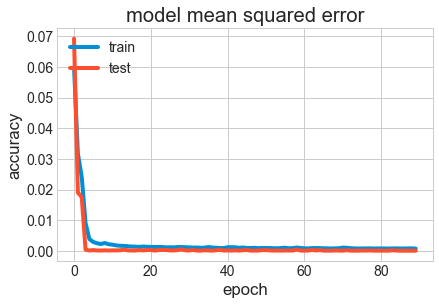

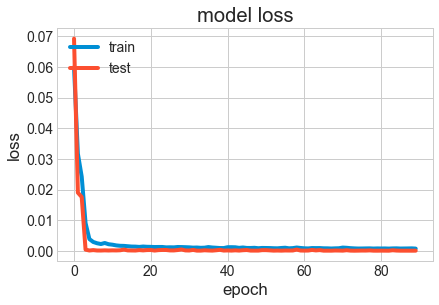

In [33]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model mean squared error')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [34]:
#Model score
def modelScore(model, XTrain, yTrain, XTest, yTest):
    trainScore = model.evaluate(XTrain, yTrain, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))
    testScore = model.evaluate(XTest, yTest, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
   

    return trainScore[0], testScore[0]

modelScore(model, XTrain, yTrain, XTest, yTest)

Train Score: 0.00035 MSE (0.02 RMSE)
Test Score: 0.00015 MSE (0.01 RMSE)


(0.00034739569951774886, 0.0001486657420025402)

In [35]:
#Denormalize the data
def denormalize(df, normalized_value): 
    df = df['Close Price'].values.reshape(-1,1)
    normalizedValue = normalized_value.reshape(-1,1)
    
    #return df.shape, p.shape
    minMaxScaler = preprocessing.MinMaxScaler()
    a = minMaxScaler.fit_transform(df)
    new = minMaxScaler.inverse_transform(normalized_value)
    return new



In [36]:
pred = model.predict(XTest)
diff=[]
ratio=[]
for u in range(len(yTest)):
    # pr = prediction day u
    pr = pred[u][0]
    ratio.append((yTest[u]/pr)-1)
    diff.append(abs(yTest[u]- pr))
    
print(pred.shape)
newp = denormalize(stockpredictdf, pred)
#print(newp)
#print(yTest.shape())
yTest = yTest.reshape(yTest.shape[0] , 1)
newyTest = denormalize(stockpredictdf, yTest)

(492, 1)


Red - Predicted Stock Prices  ,  Blue - Actual Stock Prices


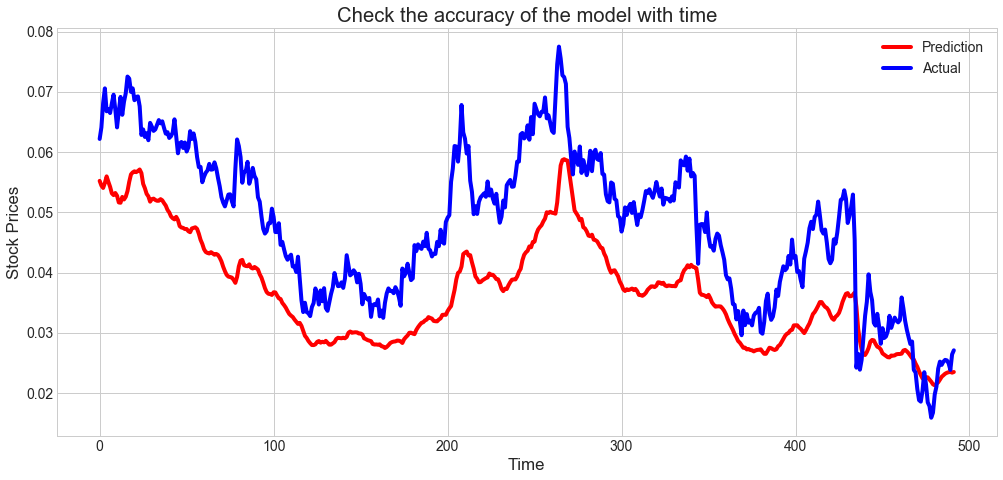

In [37]:
##Plot Actual vs pedicted stock pric
print("Red - Predicted Stock Prices  ,  Blue - Actual Stock Prices")
plt.rcParams["figure.figsize"] = (15,7)
plt.plot(newp,color='red', label='Prediction')
plt.plot(newyTest,color='blue', label='Actual')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Stock Prices')
plt.title('Check the accuracy of the model with time')
plt.grid(True)
plt.show()